<a href="https://colab.research.google.com/github/Malekkamoua/PFE/blob/main/5_Forecasting%20%7C%20ML_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
df = pd.read_csv('/content/gdrive/MyDrive/Datascience/PFE/datasets/final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [41]:
X = df[['% Silica Feed', 'Amina Flow', 'Flotation Column 01 Air Flow',
       'Flotation Column 03 Air Flow', 'Flotation Column 04 Air Flow',
       'Flotation Column 02 Level', 'Flotation Column 03 Level',
       '% Iron Concentrate']]
y = df[['% Silica Concentrate']]

X_train, y_train = X[:2000], y[:2000]
X_test, y_test = X[2000:3500], y[2000:3500]
X_val, y_val = X[3500:], y[3500:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2000, 8), (2000, 1), (1500, 8), (1500, 1), (305, 8), (305, 1))

In [49]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=200, learning_rate=0.01, objective ='reg:linear', verbosity = 0)
model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
y_test = y_test.reset_index().drop('index', axis=1)
y_test['randomeForest_predictions'] = pd.Series(predictions_test)

predictions_val = model.predict(X_val)
y_val = y_val.reset_index().drop('index', axis=1)
y_val['randomeForest_predictions'] = pd.Series(predictions_val)

Test RMSE: 0.732


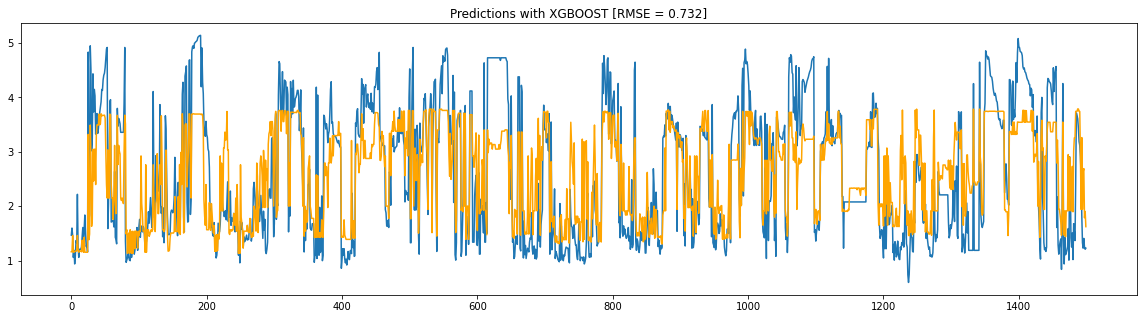

In [50]:
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(y_test['% Silica Concentrate'], predictions_test))
print('Test RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(y_test['% Silica Concentrate'])
pyplot.plot(predictions_test, color='orange')
plt.title("Predictions with XGBOOST [RMSE = %.3f]" % rmse)
pyplot.show()

RMSE: 0.698


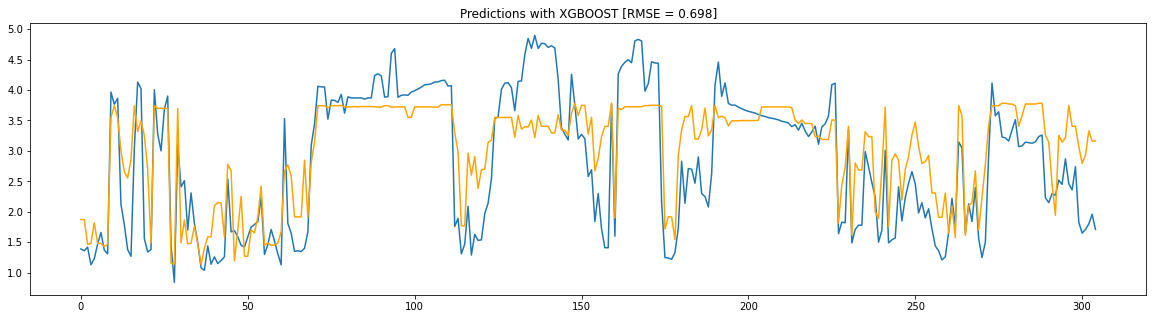

In [51]:
fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(y_val['% Silica Concentrate'], predictions_val))
print('RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(y_val['% Silica Concentrate'])
pyplot.plot(predictions_val, color='orange')
plt.title("Predictions with XGBOOST [RMSE = %.3f]" % rmse)
pyplot.show()

In [52]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100,
                                 max_features=1, oob_score=True)

model.fit(X_train, y_train)

predictions_test = model.predict(X_test)
y_test = y_test.reset_index().drop('index', axis=1)
y_test['randomeForest_predictions'] = pd.Series(predictions_test)

predictions_val = model.predict(X_val)
y_val = y_val.reset_index().drop('index', axis=1)
y_val['randomeForest_predictions'] = pd.Series(predictions_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RMSE: 0.924


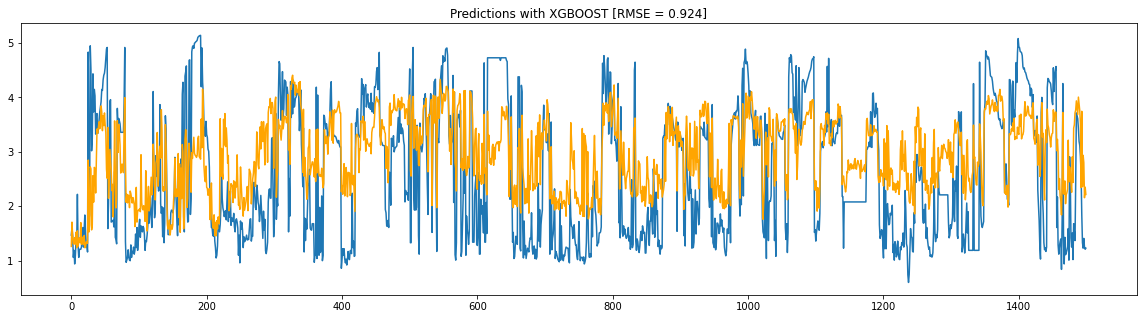

In [54]:
fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(y_test['% Silica Concentrate'], predictions_test))
print('RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(y_test['% Silica Concentrate'])
pyplot.plot(predictions_test, color='orange')
plt.title("Predictions with XGBOOST [RMSE = %.3f]" % rmse)
pyplot.show()

RMSE: 0.851


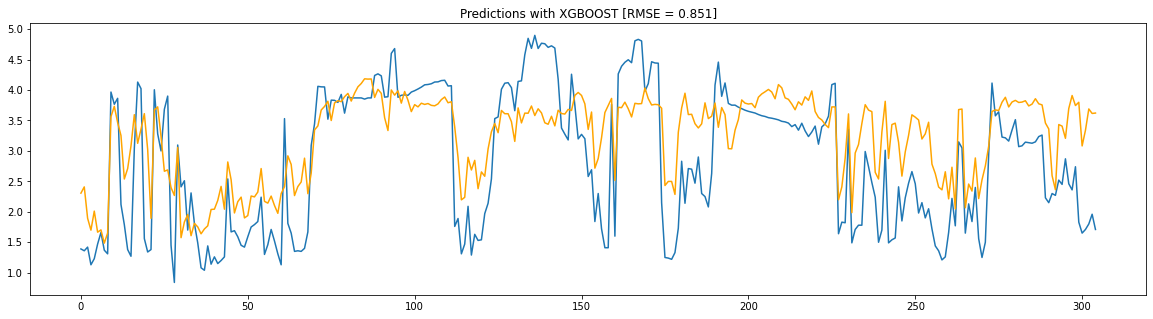

In [53]:
fig, ax = plt.subplots(figsize=(20,5))

# evaluate forecasts
rmse = sqrt(mean_squared_error(y_val['% Silica Concentrate'], predictions_val))
print('RMSE: %.3f' % rmse)

# plot forecasts against actual outcomes
pyplot.plot(y_val['% Silica Concentrate'])
pyplot.plot(predictions_val, color='orange')
plt.title("Predictions with XGBOOST [RMSE = %.3f]" % rmse)
pyplot.show()